In [1]:
library(data.table)
library(ggplot2)
library(dplyr)
library(lme4)
library(repr)

# Change plot size to 4 x 3
options(repr.plot.width = 4, repr.plot.height = 3.4, repr.plot.pointsize = 11)

DATA_DIR <- "../data/"


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: Matrix


In [2]:
get_radon_data <- function() {
    DATA_PATH <- paste0(DATA_DIR, "radon/srrs2.dat")
    data <- read.table(DATA_PATH, header = T, sep = ",")
    return(data)
}

In [3]:
prepare_data_for_state  <- function(state) {
    radon_data <- get_radon_data()
    # Get data for state
    state_data <- radon_data[radon_data["state"] == state,]
    
    # Calculate the log radon levels
    state_data$log_radon <-
        log(ifelse(state_data$activity == 0 | is.na(state_data$activity), 
                   0.1, 
                   state_data$activity))
    
    # Code counties as indices
    state_data$county_idx <- as.integer(factor(state_data$county))
    
    # county means of the radon level
    state_data <- state_data %>%
        dplyr::group_by(county_idx) %>%
        dplyr::mutate(county_mean = mean(log_radon, na.rm = TRUE))
    
    # the number of obs per county
    state_data <- state_data %>%
        dplyr::group_by(county_idx) %>%
        dplyr::mutate(nobs_county = n())
    
    # total mean of the radon level
    state_data$total_mean <- mean(state_data$log_radon)
    
    # County level variance and overall variance
    state_data <- state_data %>%
        dplyr::group_by(county_idx) %>%
        dplyr::mutate(county_var = var(log_radon, na.rm = TRUE))
    
    # To calculate the variance between counties, we first collect the county
    # level eans yet again in a separate data.table
    df <- state_data %>%
        dplyr::group_by(county_idx) %>%
        dplyr::summarise(cnty_mean = mean(log_radon, na.rm = TRUE))
    
    state_data$total_var <- var(df$cnty_mean, na.rm = TRUE)
    
    return(state_data)
}

multlevel_radon <- function(state_data) {
    state_data$multlevel_mean <- 
    ((state_data$nobs_county / state_data$county_var) * state_data$county_mean + 
    (1 / state_data$total_var) * state_data$total_mean) / 
    ((state_data$nobs_county / state_data$county_var) + (1 / state_data$total_var))
    
    return(state_data)
}

sample_mean_vs_sample_sz <- function(data_table, nobs_cutoff) {
    df <- data_table[data_table$nobs_county < nobs_cutoff, ]
    # plot(df$nobs_county, df$county_mean)
    ggplot() + 
    geom_point(data = df, aes(x = df$nobs_county, y = df$county_mean), color = "blue") 
}

radon_vs_floor <- function(data_table, county_idx) {
    df <- data_table[data_table["county_idx"] == county_idx, ]
    # plot(df$floor, df$log_radon)
    ggplot() + 
    geom_point(data = df, aes(x = df$floor, y = df$log_radon), color = "blue") 
}
 
main <- function() {
    state_data <- prepare_data_for_state("MN")
    state_data <- multlevel_radon(state_data)
    
    return(state_data)
}

In [4]:
df <- main()

###  Varying-Intercept Model with no Predictors

In [5]:
y <- df$log_radon
x <- df$floor
county <- df$county

In [6]:
M0 <- lmer(y ~ 1 + (1 | county))

summary(M0)

Linear mixed model fit by REML ['lmerMod']
Formula: y ~ 1 + (1 | county)

REML criterion at convergence: 2259.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4661 -0.5734  0.0441  0.6432  3.3516 

Random effects:
 Groups   Name        Variance Std.Dev.
 county   (Intercept) 0.09581  0.3095  
 Residual             0.63662  0.7979  
Number of obs: 919, groups:  county, 85

Fixed effects:
            Estimate Std. Error t value
(Intercept)  1.31258    0.04891   26.84

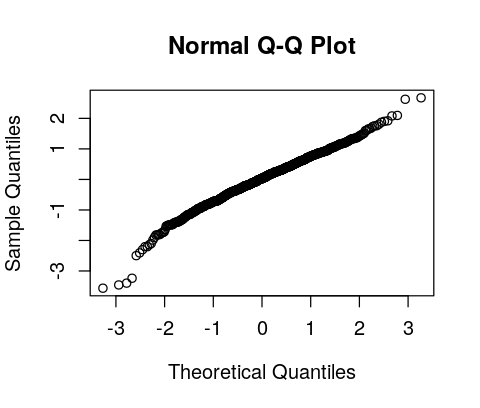

In [7]:
qqnorm(residuals(M0))

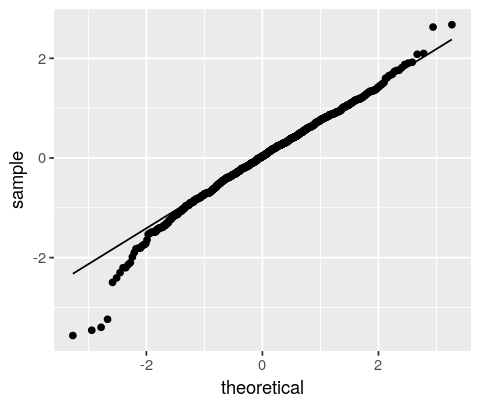

In [8]:
d <- data.frame(resids = residuals(M0))
plt <- ggplot(d, aes(sample = resids)) 
plt + stat_qq() + stat_qq_line()

In [9]:
ranef(M0)

$county
                      (Intercept)
AITKIN               -0.245076616
ANOKA                -0.425019157
BECKER               -0.082194723
BELTRAMI             -0.088031495
BENTON               -0.022599857
BIG STONE             0.062347769
BLUE EARTH            0.404619762
BROWN                 0.119023360
CARLTON              -0.229262875
CARVER               -0.051693984
CASS                  0.038026098
CHIPPEWA              0.156955204
CHISAGO              -0.129949605
CLAY                  0.318690510
CLEARWATER           -0.125841299
COOK                 -0.149858547
COTTONWOOD           -0.217273295
CROW WING            -0.238890328
DAKOTA               -0.018106714
DODGE                 0.151717918
DOUGLAS               0.196377451
FARIBAULT            -0.377659062
FILLMORE             -0.063129213
FREEBORN              0.361814207
GOODHUE               0.362955970
HENNEPIN             -0.025844465
HOUSTON               0.104680721
HUBBARD              -0.216117867
ISANTI

### Varying-Intercept Model with an Individual-Level Predictor

In [10]:
M1 <- lmer(y ~ x + (1 | county))
summary(M1)

Linear mixed model fit by REML ['lmerMod']
Formula: y ~ x + (1 | county)

REML criterion at convergence: 2171.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3989 -0.6155  0.0029  0.6405  3.4281 

Random effects:
 Groups   Name        Variance Std.Dev.
 county   (Intercept) 0.1077   0.3282  
 Residual             0.5709   0.7556  
Number of obs: 919, groups:  county, 85

Fixed effects:
            Estimate Std. Error t value
(Intercept)  1.46160    0.05158  28.339
x           -0.69299    0.07043  -9.839

Correlation of Fixed Effects:
  (Intr)
x -0.288

Thus $y_i = 1.46160 + \mbox{ random effect}_{j[i]} - 0.69299 \cdot x_i$, where $j[i]$ is the county that the $i$th house belongs to. The within-county standard deviation $\sigma_y = 0.7556$ and the across-county standard deviation $\sigma_a = 0.3282$. 